In [1]:
%%bash

wget -q https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('daily-min-temperatures.csv')
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
data.isnull().sum()

Date    0
Temp    0
dtype: int64

In [4]:
# запишем дату в индекс
data['Date'] = pd.to_datetime(data['Date'])
data["timeIndex"] = data.Date - data.Date.min()
data["timeIndex"] =  data["timeIndex"] / np.timedelta64(1, 'D')
data = data.set_index('Date')
data.head()

,Temp,timeIndex
Date,,
1981-01-01,20.7,0.0
1981-01-02,17.9,1.0
1981-01-03,18.8,2.0
1981-01-04,14.6,3.0
1981-01-05,15.8,4.0


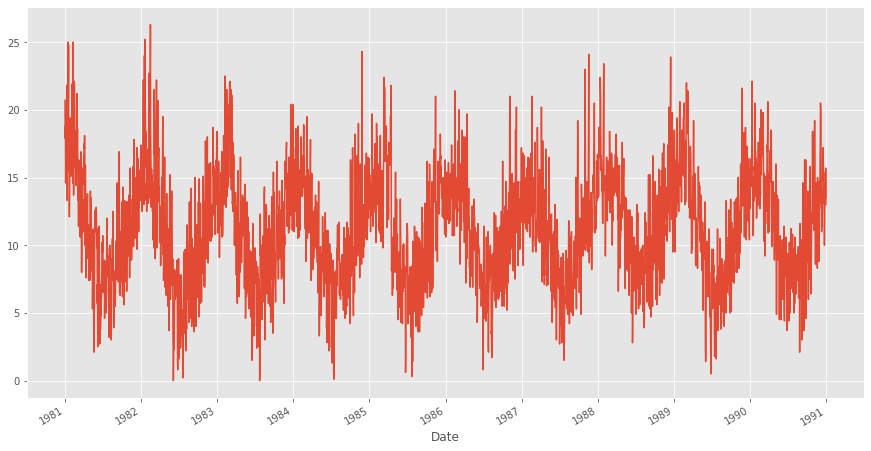

In [5]:
# изобразим зависимость температуры от времени
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
data.Temp.plot();

In [6]:
data.describe()

,Temp,timeIndex
count,3650.000000,3650.000000
mean,11.177753,1825.300000
std,4.071837,1054.501522
min,0.000000,0.000000
25%,8.300000,912.250000
50%,11.000000,1825.500000
75%,14.000000,2737.750000
max,26.300000,3651.000000


In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data['Temp_norm'] = scaler.fit_transform(data['Temp'].values.astype(float).reshape(-1, 1))
data.head()

,Temp,timeIndex,Temp_norm
Date,,,
1981-01-01,20.7,0.0,0.574144
1981-01-02,17.9,1.0,0.361217
1981-01-03,18.8,2.0,0.429658
1981-01-04,14.6,3.0,0.110266
1981-01-05,15.8,4.0,0.201521


In [8]:
data_train = data[:2750]
data_test = data[2750:]
print(data_train.shape, data_test.shape)

(2750, 3) (900, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


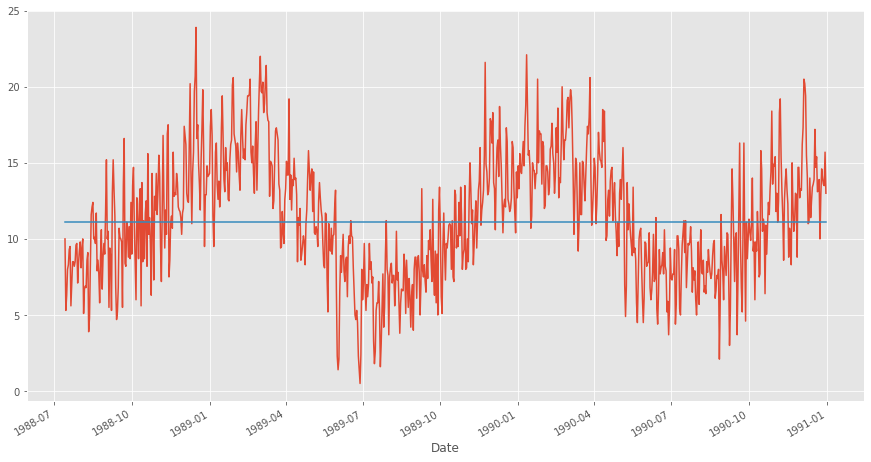

In [9]:
# прогнозирование средним
model_mean_pred = data_train.Temp_norm.mean()
data_test["pred_mean"] = scaler.inverse_transform(np.array(model_mean_pred).reshape(-1, 1)).item()

data_test.Temp.plot()
data_test.pred_mean.plot()

In [10]:
def RMSE(predicted, actual):
    se = (predicted - actual)**2
    mse = se.sum() / se.count()
    rmse = np.sqrt(mse)
    return rmse

model_mean_RMSE = RMSE(model_mean_pred, data_test.Temp_norm)
model_mean_RMSE

0.305610753340555

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

baseline = smf.ols('Temp_norm ~ timeIndex', data = data_train).fit()
data_test["baseline_pred_norm"] = baseline.predict(data_test)
data_test['baseline_pred'] = scaler.inverse_transform(np.array(data_test["baseline_pred_norm"]).reshape(-1, 1))

model_mean_RMSE = RMSE(data_test.baseline_pred_norm, data_test.Temp_norm)
model_mean_RMSE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


0.30652810973760086

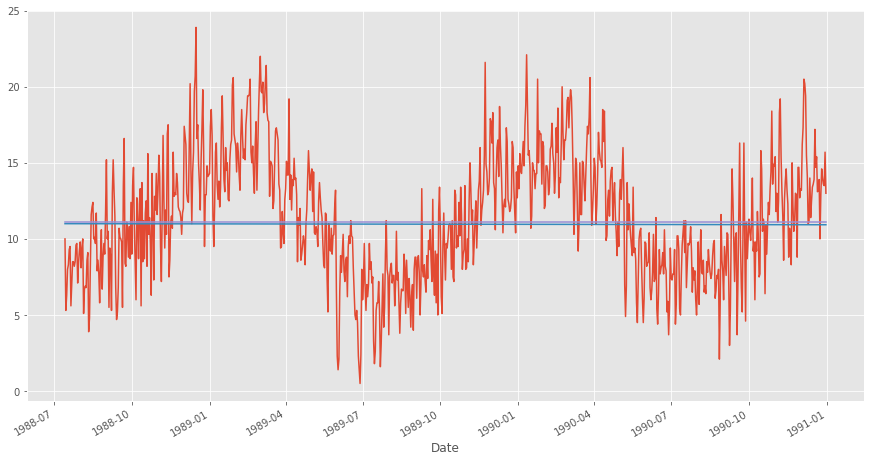

In [12]:
data_test.Temp.plot()
data_test.baseline_pred.plot()
data_test.pred_mean.plot()

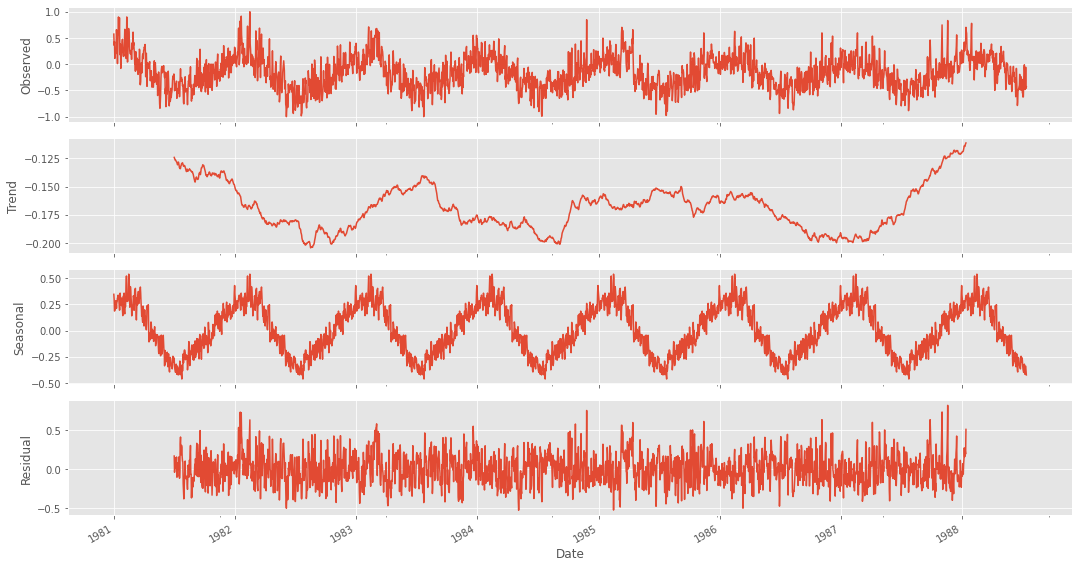

In [13]:
# декомпозируем ряд на тренд и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose

#data_train.index = data_train.index.to_timestamp()
decomposition = seasonal_decompose(data_train.Temp_norm, model="additive", freq=365)
decomposition.plot();

In [14]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Построим ряд по тренду и сезонности
data_test['pred_decomp_norm'] = seasonal[194:1094].values + trend[194:1094].values
data_test['pred_decomp'] = scaler.inverse_transform(np.array(data_test["pred_decomp_norm"]).reshape(-1, 1))

model_Decomp_RMSE = RMSE(data_test.pred_decomp_norm, data_test.Temp_norm)
model_Decomp_RMSE

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


0.2080732039913231

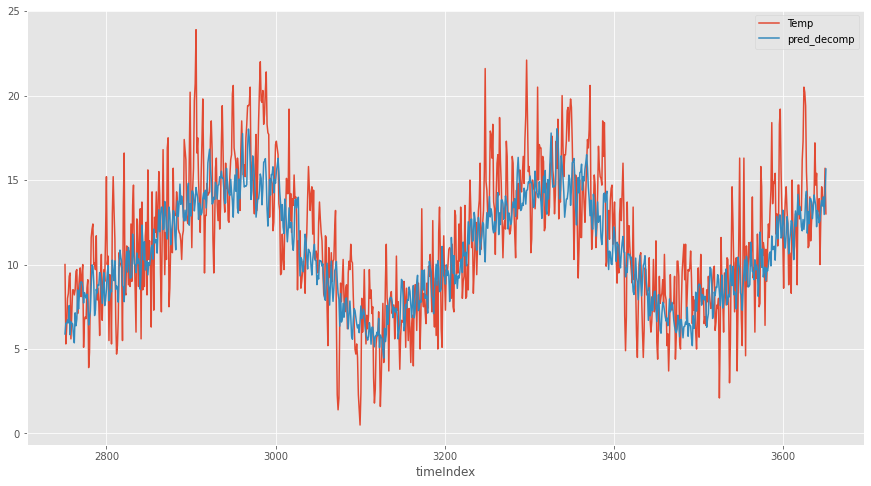

In [15]:
data_test.plot(kind="line", x="timeIndex", y = ["Temp", "pred_decomp"])

In [27]:
train_data = data_train['Temp'].values.astype(float)
test_data = data_test['Temp'].values.astype(float)

In [16]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler(feature_range=(-1, 1))
#train_data_normalized = scaler.fit_transform(y_train.reshape(-1, 1))
#train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized = torch.FloatTensor(data_train.Temp_norm).view(-1)
test_data_normalized = torch.FloatTensor(data_test.Temp_norm).view(-1)

#test_data_normalized = scaler.transform(y_test.reshape(-1, 1))
#test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [17]:
train_window = 365

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)


    def forward(self, input_seq):
        lstm_out, hidden = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [179]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [180]:
epochs = 3

model.cuda()

for i in range(epochs):
    for seq, labels in train_inout_seq:
        seq = seq.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        

    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00181450
epoch:   1 loss: 0.00000109
epoch:   2 loss: 0.00051815
epoch:   2 loss: 0.0005181480


In [185]:
# предсказываем на 1 день вперёд
data_for_test = torch.cat((train_data_normalized[-365:], test_data_normalized))
test_seq_1 = create_inout_sequences(data_for_test, train_window)
test_outputs = []
losses_1 = []

for x, y in test_seq_1:
    with torch.no_grad():
        y = y.cuda()
        ans = model(x.cuda())
        test_outputs.append(ans.item())
        #print(y, ans)
        single_loss = loss_function(y, ans)
        losses_1.append(single_loss.item())

actual_predictions_1 = scaler.inverse_transform(np.array(test_outputs).reshape(-1, 1))
print('RMSE', np.sqrt(np.mean(losses_1)))

RMSE 0.22436373398243556


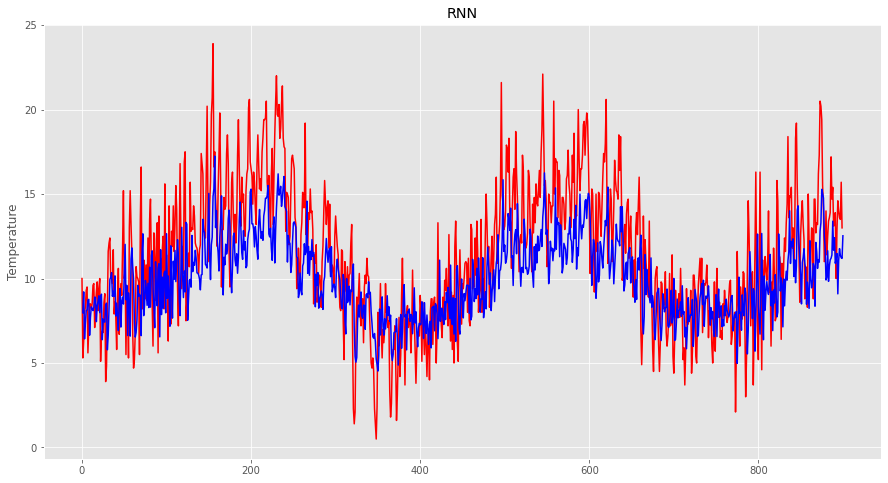

In [186]:
from pylab import rcParams 

rcParams['figure.figsize'] = 15, 8 
x = np.arange(1, 901, 1)
plt.title('RNN')
plt.ylabel('Temperature')
plt.grid(True)
plt.autoscale(axis='days', tight=True)
plt.plot(test_data, color='red')
plt.plot(x, actual_predictions_1, color='blue')
plt.show()

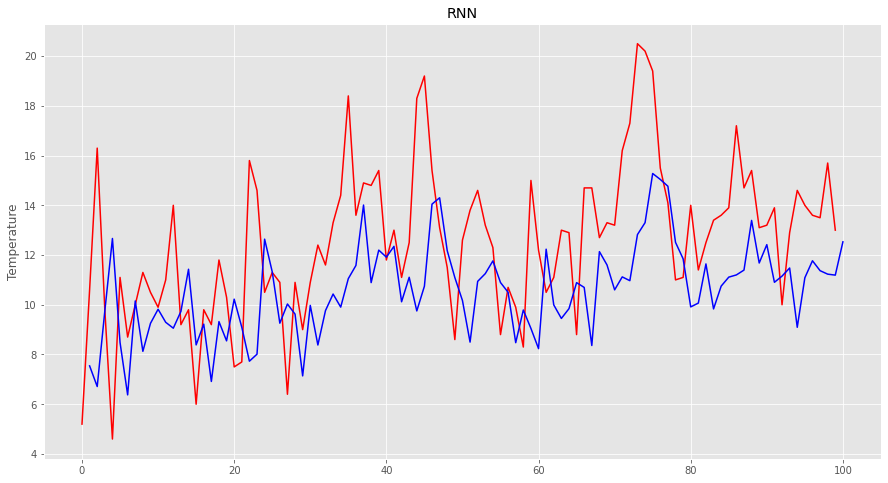

In [187]:
# только последние 100 дней
x = np.arange(1, 101, 1)
plt.title('RNN')
plt.ylabel('Temperature')
plt.grid(True)
plt.autoscale(axis='days', tight=True)
plt.plot(test_data[-100:], color='red')
plt.plot(x, actual_predictions_1[-100:], color='blue')
plt.show()

In [188]:
# предсказываем на 3 дня вперёд
test_data_3 = train_data_normalized[-365:].cuda()

data_for_test_3 = torch.cat((train_data_normalized[-365:], test_data_normalized))
test_seq_3 = create_inout_sequences(data_for_test_3, train_window)

test_results = []
losses = []

for i in range(900):
    with torch.no_grad():
        ans = model(test_data_3)
        test_data_3 = torch.cat((test_data_3[1:len(test_data_3)], ans))
        if i >= 3:
            test_data_3 = torch.cat((test_data_3[0:len(test_data_3) - 3], test_seq_3[i-3][1].cuda(), test_data_3[len(test_data_3) - 2: len(test_data_3)]))
        test_results.append(ans.item())
        single_loss = loss_function(ans, test_seq_3[i][1].cuda())
        losses.append(single_loss.item())

actual_predictions2 = scaler.inverse_transform(np.array(test_results).reshape(-1, 1))
print('RMSE: ', np.sqrt(np.mean(losses)))

RMSE:  0.3631010183872377


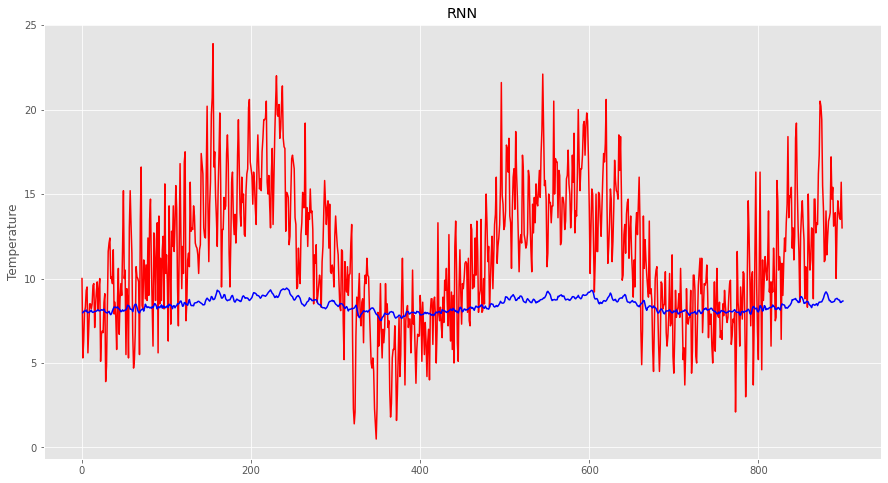

In [189]:
from pylab import rcParams 

rcParams['figure.figsize'] = 15, 8 
x = np.arange(1, 901, 1)
plt.title('RNN')
plt.ylabel('Temperature')
plt.grid(True)
plt.autoscale(axis='days', tight=True)
plt.plot(test_data, color='red')
plt.plot(x, actual_predictions2, color='blue')
plt.show()

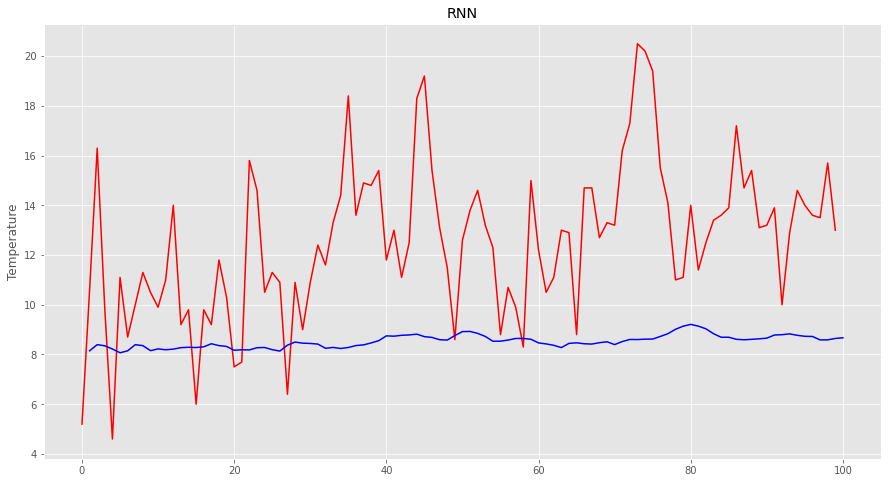

In [190]:
# только последние 100 дней
x = np.arange(1, 101, 1)
plt.title('RNN')
plt.ylabel('Temperature')
plt.grid(True)
plt.autoscale(axis='days', tight=True)
plt.plot(test_data[-100:], color='red')
plt.plot(x, actual_predictions2[-100:], color='blue')
plt.show()

In [191]:
# CNN
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

#raw_seq = [10,20,30,40,50,60,70,80,90]
n_steps = 365
train_x, train_y = split_sequence(data_train['Temp_norm'].values.astype(float), n_steps)
valid_x, valid_y = split_sequence(data_test['Temp_norm'].values.astype(float), n_steps)

In [192]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1d = nn.Conv1d(365, 64, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [193]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_CNN = CNN()
model_CNN.cuda()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [194]:
train_data_normalized_CNN = torch.FloatTensor(train_x)
train_labels_normalized_CNN = torch.FloatTensor(train_y)

test_data_normalized_CNN = torch.FloatTensor(valid_x)
test_labels_normalized_CNN = torch.FloatTensor(valid_y)

In [195]:
from torch.utils.data import Dataset, DataLoader

class TempDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [196]:
train = TempDataset(train_x.reshape(train_x.shape[0], train_x.shape[1], 1), train_y)
valid = TempDataset(valid_x.reshape(valid_x.shape[0], valid_x.shape[1], 1), valid_y)

train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=False)

In [199]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model_CNN.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        #print(idx, inputs.shape, labels.shape)
        labels = labels.cuda()
        optimizer.zero_grad()
        preds = model_CNN(inputs.float())
        loss = criterion(preds, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss)

    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model_CNN.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            #print(idx)
            optimizer.zero_grad()
            preds = model_CNN(inputs.float())
            loss = criterion(preds, labels.float())
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'valid_loss {valid_loss}')

In [200]:
# fit
epochs = 10

for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()

epochs 1/10
train_loss 0.045913003385066986
valid_loss 0.03489435464143753
epochs 2/10
train_loss 0.04439752921462059
valid_loss 0.03488955646753311
epochs 3/10
train_loss 0.04348422959446907
valid_loss 0.03488655015826225
epochs 4/10
train_loss 0.04266238957643509
valid_loss 0.03483601659536362
epochs 5/10
train_loss 0.04188812896609306
valid_loss 0.034766245633363724
epochs 6/10
train_loss 0.041126903146505356
valid_loss 0.03468765690922737
epochs 7/10
train_loss 0.04036381095647812
valid_loss 0.034586042165756226
epochs 8/10
train_loss 0.03958564251661301
valid_loss 0.03449857607483864
epochs 9/10
train_loss 0.03880440816283226
valid_loss 0.034402620047330856
epochs 10/10
train_loss 0.03801877796649933
valid_loss 0.03430018573999405


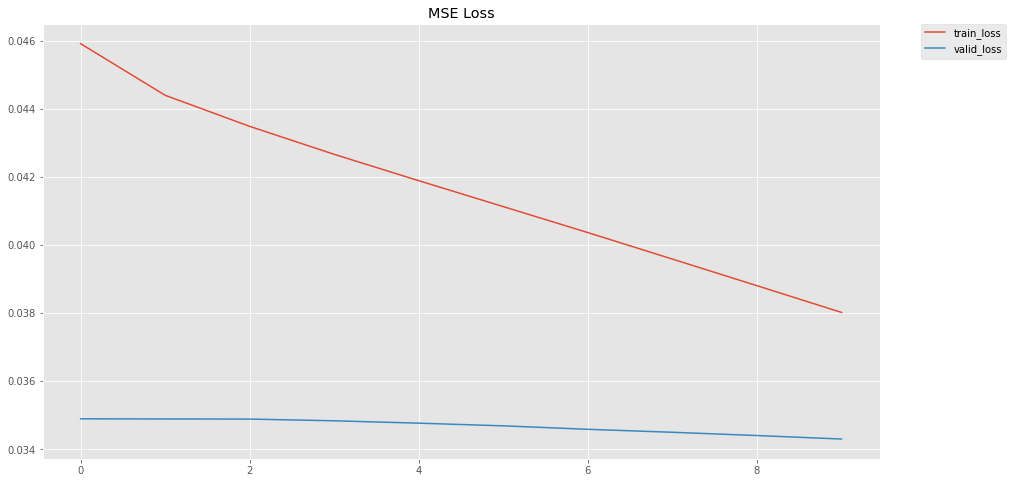

In [201]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
#plt.ylim(0, 0.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [205]:
# predict
model_CNN.eval()
prediction = []
batch_size = 1
running_loss = 0

res_data = np.hstack((data_train['Temp_norm'].values.astype(float)[-365:], data_test['Temp_norm'].values.astype(float)))
test_x, test_y = split_sequence(res_data, n_steps)
test = TempDataset(test_x.reshape(test_x.shape[0], test_x.shape[1], 1), test_y)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)
#target_x, target_y = split_sequence(train_set.Elec_kW.values,n_steps)
#inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

#iterations =  int(inputs.shape[0]/2)

for idx, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    preds = model_CNN(inputs.float())
    prediction.append(preds)
    loss = criterion(preds, labels.float())
    running_loss += loss

#print(running_loss.item())
np.sqrt(running_loss.item()/len(test_loader))

0.19536413163034846

In [206]:
actual_predictions_CNN = scaler.inverse_transform(np.array(prediction).reshape(-1, 1))

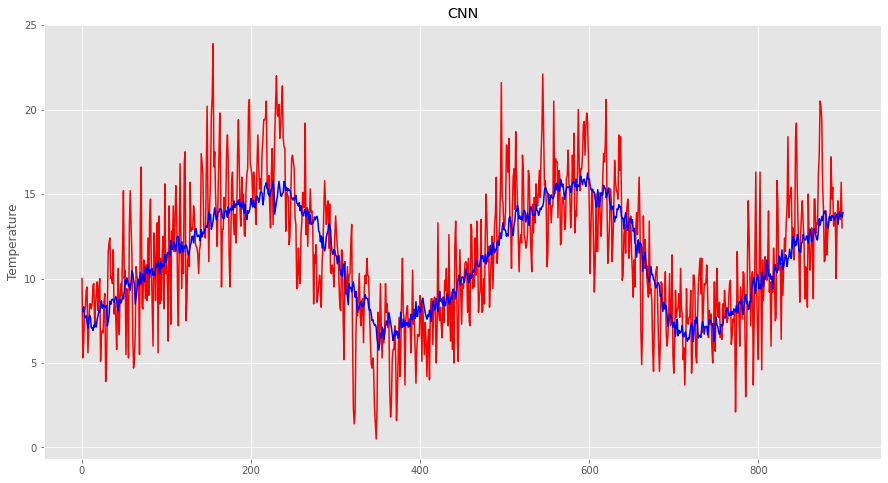

In [207]:
from pylab import rcParams 

rcParams['figure.figsize'] = 15, 8 
x = np.arange(1, 901, 1)
plt.title('CNN')
plt.ylabel('Temperature')
plt.grid(True)
plt.autoscale(axis='days', tight=True)
plt.plot(test_data, color='red')
plt.plot(x, actual_predictions_CNN, color='blue')
plt.show()

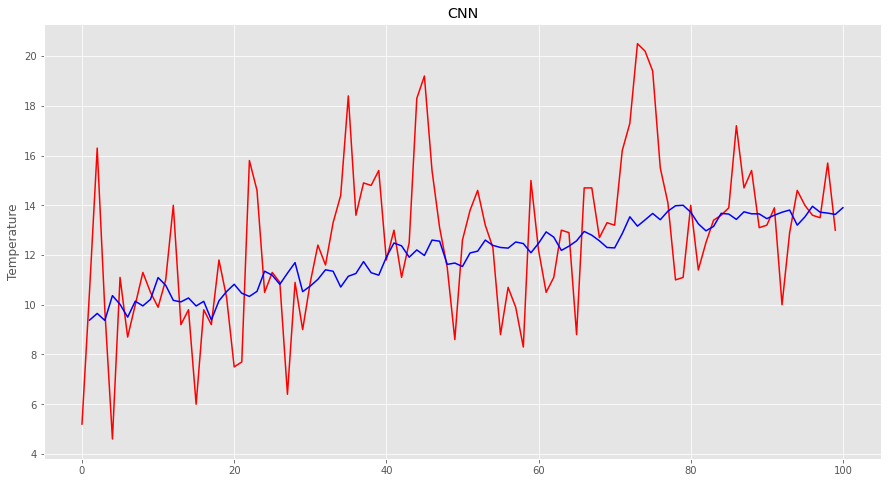

In [208]:
rcParams['figure.figsize'] = 15, 8 
x = np.arange(1, 101, 1)
plt.title('CNN')
plt.ylabel('Temperature')
plt.grid(True)
plt.autoscale(axis='days', tight=True)
plt.plot(test_data[-100:], color='red')
plt.plot(x, actual_predictions_CNN[-100:], color='blue')
plt.show()